## Time Series Tasks

1. Converting the longitudinal blood pressure measurements into a proper time series:

In [13]:
!pip install pandas
!pip install matplotlib
!pip install statsmodels
!pip install seaborn
!pip install numpy

import pandas as pd

df = pd.read_csv('patient_longitudinal.csv', delimiter='\t')       #reading in the data
df.columns        #checking column names

Index(['patient_id', 'visit_date', 'bp_systolic', 'heart_rate',
       'adverse_event', 'age', 'sex', 'bmi', 'smoking', 'diabetes'],
      dtype='object')

In [3]:
#converting visit_date to date time
df['visit_date'] = pd.to_datetime(df['visit_date'], format='%Y-%m-%d')

#sorting the dataframe by visit_date
df.sort_values(by='visit_date', inplace=True)

#group by patient_id and visit_date, and average all columns in order to remove exact duplicates and aggregate measurements for duplicate dates by calculating the mean
df = df.groupby(['patient_id', 'visit_date'], as_index=False).mean()

#interpolate missing values in specific columns
df['bp_systolic'] = df['bp_systolic'].interpolate(method='linear')
df['heart_rate'] = df['heart_rate'].interpolate(method='linear')

#checking for missing values
df.isnull().sum()

patient_id       0
visit_date       0
bp_systolic      0
heart_rate       0
adverse_event    0
age              0
sex              0
bmi              0
smoking          0
diabetes         0
dtype: int64

2. Analyzing blood pressure trends:

/tmp/ipykernel_27505/2295454234.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_bp = df['bp_systolic'].resample('M').mean()


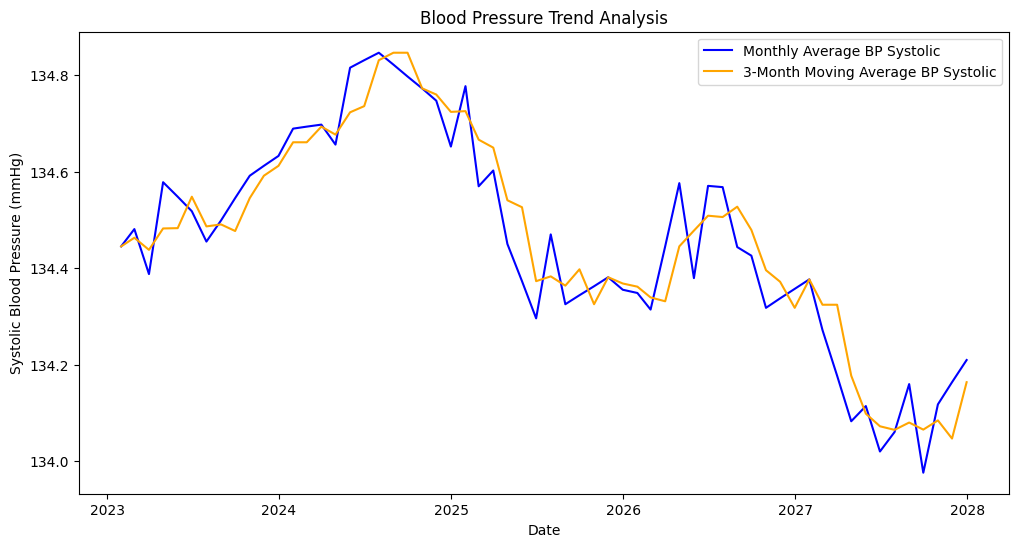

In [4]:
import matplotlib.pyplot as plt


#sort data by patient and visit_date
df.sort_values(by=['patient_id', 'visit_date'], inplace=True)

# Set the index to visit_date resampling
df.set_index('visit_date', inplace=True)

#resample data monthly and calculate mean for bp_systolic
monthly_bp = df['bp_systolic'].resample('M').mean()

#calculate 3-month moving average
monthly_bp_smoothed = monthly_bp.rolling(window=3, min_periods=1).mean()

#interpolating to fill in gaps
monthly_bp = monthly_bp.interpolate()
monthly_bp_smoothed = monthly_bp_smoothed.interpolate()

#plot the original monthly average and the smoothed trend
plt.figure(figsize=(12, 6))
plt.plot(monthly_bp, label='Monthly Average BP Systolic', color='blue')
plt.plot(monthly_bp_smoothed, label='3-Month Moving Average BP Systolic', color='orange')
plt.title('Blood Pressure Trend Analysis')
plt.xlabel('Date')
plt.ylabel('Systolic Blood Pressure (mmHg)')
plt.legend()
plt.show()

# Analysis: 
- There is an overall decline in blood pressure (BP) observed over time. Values peak at from 2024 to 2025, then peak sligtly peak again in the middle of 2026. The fluctuations in BP remain relatively small, with the values predominantly staying within a narrow range of approximately 134 to 134.8. This limited variation indicates that, despite the gradual downward trend, the overall BP levels remain fairly stable throughout the observed period.

## Statistical Modeling Tasks

1. Analyze factors affecting baseline blood pressure:

                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     2698.
Date:                Wed, 06 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:52:48   Log-Likelihood:            -2.5551e+05
No. Observations:               60000   AIC:                         5.110e+05
Df Residuals:                   59995   BIC:                         5.111e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        110.2999      0.450    245.155      0.0

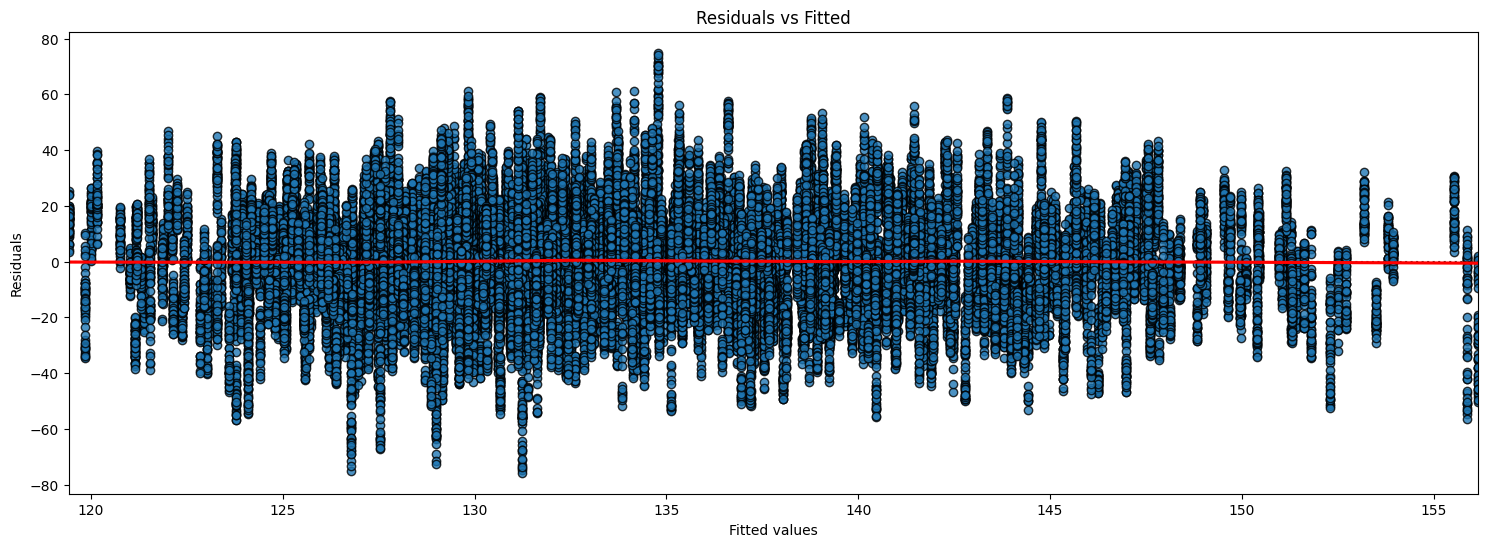

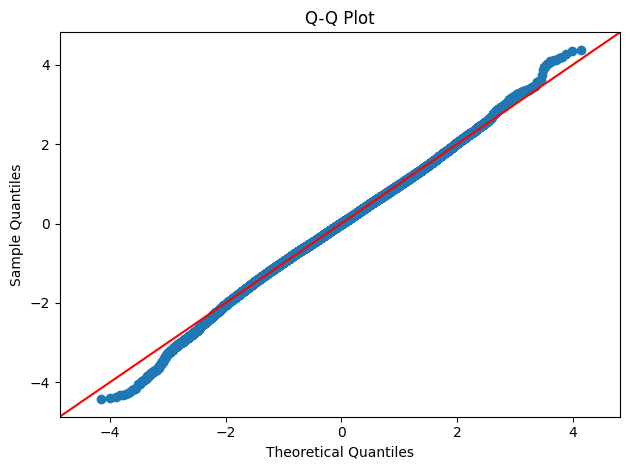

                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     2705.
Date:                Wed, 06 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:52:50   Log-Likelihood:            -2.5551e+05
No. Observations:               60000   AIC:                         5.110e+05
Df Residuals:                   59995   BIC:                         5.111e+05
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        110.2999      0.457    241.359      0.0

In [12]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


#target variable (y) and predictors
y = df['bp_systolic']
X = df[['age', 'bmi', 'smoking', 'diabetes']]

#constant term to the predictors for the intercept
X = sm.add_constant(X)

#fitting and printing the model
model = sm.OLS(y, X).fit()
print(model.summary())

#residuals vs fitted Values
plt.figure(figsize=(40, 6))
plt.subplot(1, 2, 2)
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, line_kws={'color': 'red'}, scatter_kws={'edgecolor': 'black'})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')

#Q-Q Plot
plt.subplot(1, 2, 2)
sm.qqplot(model.resid, line='45', fit=True)
plt.title('Q-Q Plot')
plt.tight_layout()
plt.show()

#standard errors
model_se = sm.OLS(y, X).fit(cov_type='HC3')
print(model_se.summary())



# Analysis: 
- OLS regression results indicate that the independent variables: age, BMI, smoking, and diabetes—are all statistically significant predictors of systolic blood pressure (BP), with p-values of 0.000. The model explains approximately 15.2% of the variance in BP, as indicated by the R-squared value of 0.152. Among the predictors, diabetes has the highest coefficient (9.6893), followed by smoking (5.6040), suggesting that both factors have a notable positive influence on BP. 

2. Model treatment effectiveness:

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      989
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -612.39
Date:                Wed, 06 Nov 2024   Deviance:                       1224.8
Time:                        19:10:27   Pearson chi2:                     997.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1017
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.3432      1.319     -1.018      

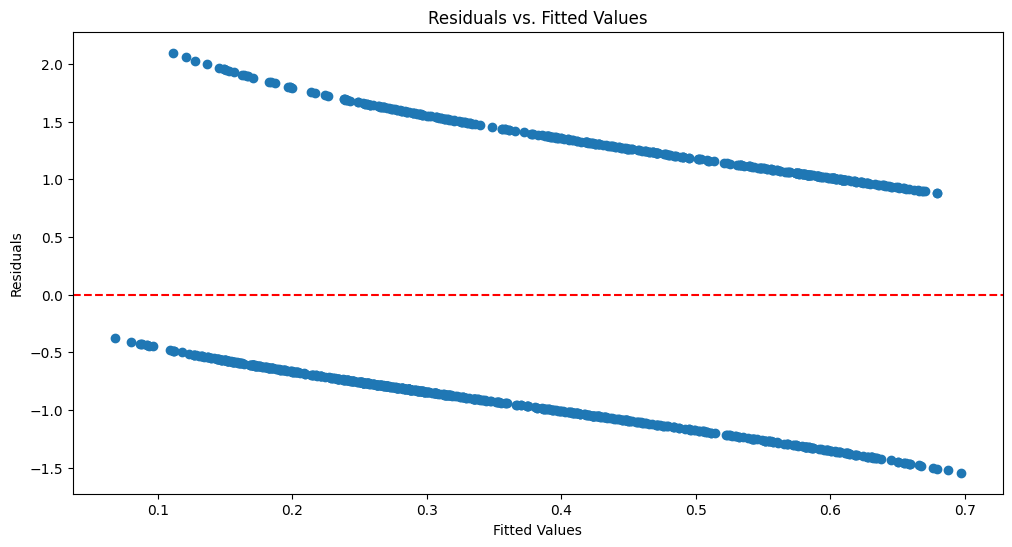

In [28]:
#loading CSV files
df_treatment = pd.read_csv('patient_treatment.csv', delimiter='\t')

import numpy as np

#predictors and response variable
X = df_treatment[['age', 'sex', 'bmi', 'smoking', 'diabetes', 'bp_systolic', 'cholesterol','heart_rate', 'treatment', 'adherence']]
X = sm.add_constant(X)  
y = df_treatment['outcome']       #treatment success outcome

#GLM model
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()

#odds ratios and confidence intervals
odds_ratios = np.exp(model.params)
confidence_intervals = np.exp(model.conf_int())
print(model.summary())
print("Odds Ratios:\n", odds_ratios)
print("Confidence Intervals:\n", confidence_intervals)

#deviance
print("Residual Deviance:", model.deviance)
print("Null Deviance:", model.null_deviance)

#influence and diagnostic plots
influence = model.get_influence()
residuals = model.resid_deviance

#plot residuals to assess model fit
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.scatter(model.fittedvalues, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()


# Analysis: 

- Generalized Linear Model (GLM) results show that several factors significantly influence the treatment outcome, with diabetes and smoking having the most substantial negative effects, as indicated by their coefficients (-0.7151 and -0.5921, respectively) and low p-values (both < 0.01). The treatment variable, with a coefficient of 1.3901 and an odds ratio of 4.015, strongly predicts a higher likelihood of treatment success. Age, sex, BMI, BP systolic, cholesterol, heart rate, and adherence have weak or non-significant effects on the outcome, with p-values above 0.05. 

## Machine Learning Tasks (stretch goal)

1. Build a prediction pipeline:

In [32]:
!pip install scikit-learn

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

data = pd.read_csv('patient_treatment.csv', delimiter='\t')

#features and target variable
X = data[['age', 'sex', 'bmi', 'smoking', 'diabetes', 'bp_systolic', 'cholesterol', 'heart_rate', 'treatment', 'adherence']]  #features
y = data['outcome']  #target variable

#splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#pipeline with preprocessing and logistic regression
pipeline = make_pipeline(
    StandardScaler(),  
    LogisticRegression(
        penalty='l2',  
        solver='lbfgs',  
        max_iter=1000,  
        class_weight='balanced', 
    )
)

#training
scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

#print cross-validation scores
print("Cross-validation accuracy scores:", scores)
print("Mean accuracy:", scores.mean())

#fitting the model on the full training data
pipeline.fit(X_train, y_train)

#evaluating the model on the test set
test_accuracy = pipeline.score(X_test, y_test)
print(f"Test set accuracy: {test_accuracy}")


Cross-validation accuracy scores: [0.65    0.6375  0.6375  0.54375 0.7125 ]
Mean accuracy: 0.63625
Test set accuracy: 0.6


# Analysis: 
- The cross-validation accuracy scores range from 54.38% to 71.25%, indicating variability in model performance across different folds. The mean accuracy of 63.63% suggests a moderate overall performance, however there is room for improvement. The test set accuracy of 60% is slightly lower than the cross-validation mean, suggesting that the model may not generalize well to new data. These results suggest that the model is reasonably good but may benefit from tuning to improve consistency and accuracy.

2. Validate model performance:

Cross-validation results:
Accuracy: [0.65714286 0.6        0.65       0.55714286 0.63571429]
Precision: [0.53968254 0.48484848 0.53968254 0.44117647 0.52459016]
Recall: [0.64150943 0.59259259 0.62962963 0.55555556 0.59259259]
ROC AUC: [0.73346346 0.62618432 0.65783807 0.60443583 0.70219638]
Mean Accuracy: 0.62

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.72      0.61      0.66       185
           1       0.50      0.63      0.55       115

    accuracy                           0.61       300
   macro avg       0.61      0.62      0.61       300
weighted avg       0.64      0.61      0.62       300



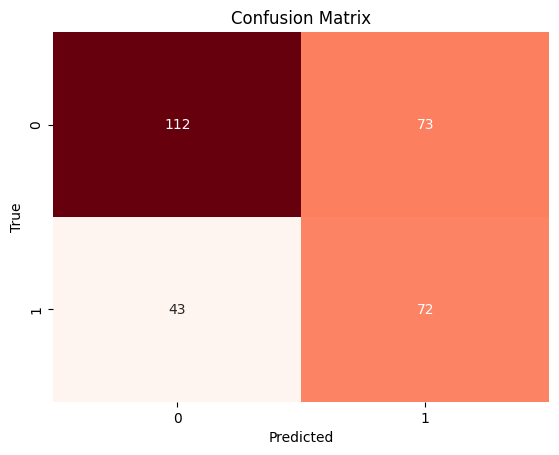

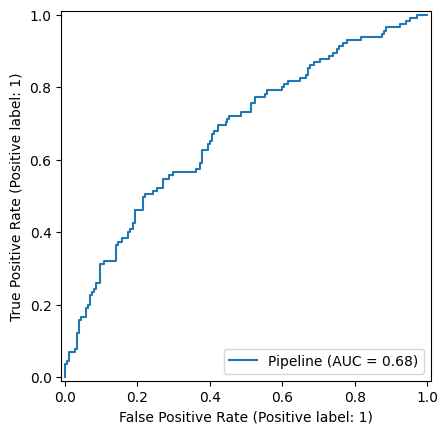

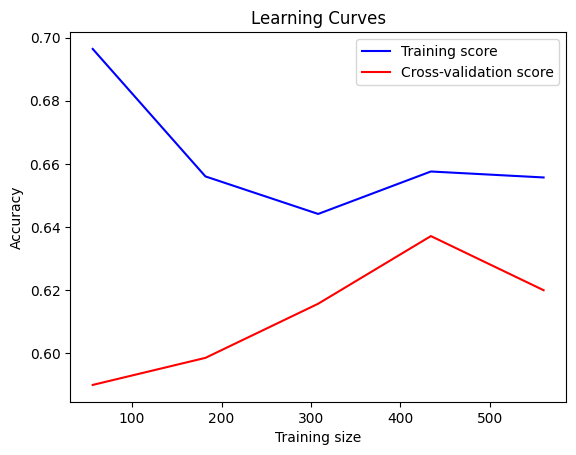

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, learning_curve  # Add learning_curve import here
from sklearn.metrics import classification_report, RocCurveDisplay, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

#split data into 70% training and 30% test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

#create a pipeline
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=42)
)

#stratifiedKFold for 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#cross-validation with multiple metrics: accuracy, precision, recall, and ROC AUC
scores = cross_validate(
    pipeline,
    X_train, y_train,
    cv=cv,
    scoring=['accuracy', 'precision', 'recall', 'roc_auc'],
)

#print cross-validation results
print("Cross-validation results:")
print(f"Accuracy: {scores['test_accuracy']}")
print(f"Precision: {scores['test_precision']}")
print(f"Recall: {scores['test_recall']}")
print(f"ROC AUC: {scores['test_roc_auc']}")
print(f"Mean Accuracy: {scores['test_accuracy'].mean()}")

#train the model on training set
pipeline.fit(X_train, y_train)

#predict on the test set
y_pred = pipeline.predict(X_test)

#print classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

#confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

#plot ROC curve
RocCurveDisplay.from_estimator(pipeline, X_test, y_test)

#plot learning curves to diagnose bias/variance
train_sizes, train_scores, test_scores = learning_curve(
    pipeline,
    X_train, y_train,
    cv=cv,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='accuracy'
)

#plot the learning curves
plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Training score", color='blue')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label="Cross-validation score", color='red')
plt.xlabel("Training size")
plt.ylabel("Accuracy")
plt.title("Learning Curves")
plt.legend(loc="best")
plt.show()


# Analysis: 
- The cross-validation results show an average accuracy of 62%, with some variation in performance across folds, ranging from 55.7% to 65.7%. The model's precision is generally lower for class 1 (positive outcomes), indicating a higher rate of false positives, while recall is relatively higher for class 1, suggesting better detection of positive outcomes. The test set classification report shows an accuracy of 61%, with precision and recall for class 1 being 50% and 63%, respectively, indicating that there could be improvement in detecting positive cases. The confusion matrix reveals 112 true negatives, 73 false positives, 43 false negatives, and 72 true positives, indicating some imbalance between the two classes.
- The AUC for the test set is 0.68, which suggests that the model has moderate ability to correctly distinguish between a randomly chosen positive case and a randomly chosen negative case. While the AUC is above 0.5, it is still below 0.8, indicating that there is room for improvement in the model's ability to accurately classify both positive and negative outcomes.